In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
import pathlib

COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

Using TensorFlow backend.


In [2]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES

In [4]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")

In [5]:
def make_feat(df):
    counts = df[["userId"]].groupby("itemId").count()
    feat = df.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    return feat

In [6]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [11]:
def make_model(units):
    K.clear_session()
    
    y = x = layers.Input(shape=(21,))
    
    y = layers.Dense(
        units=units * 8,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation="relu"
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [38]:
def train_model(batch_size, units, epochs=40):
    model = make_model(units)
    
    lr=0.001
    
    # Предварительное обучение на MAE
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss="mean_absolute_error",
                  metrics=[intersection_over_union]
    )
    model.fit(
        x= make_feat(votes),
        y=answers,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[callbacks.EarlyStopping(monitor='intersection_over_union', patience=epochs // 10, verbose=10)],
        validation_data=None,
    )
    
    # ФИнальное обучение
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs // 10, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
    ]
    model.fit(
        x= make_feat(votes),
        y=answers,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=[make_feat(votes), answers],
    )
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs // 10, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
    ]
    rez = model.fit(
        x= make_feat(votes),
        y=answers,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=[make_feat(votes), answers],
    )
    return rez, model

In [39]:
rez, model = train_model(1, 16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2816      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 13,748
Trainable params: 13,748
Non-trainable params: 0
_________________________________________________________________
Epoch 


Epoch 00013: val_loss did not improve from -0.58810

Epoch 00013: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 14/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5859 - val_loss: -0.5802

Epoch 00014: val_loss did not improve from -0.58810

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 15/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5879 - val_loss: -0.5897

Epoch 00015: val_loss improved from -0.58810 to -0.58969, saving model to ../processed/model.h5
Epoch 16/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5881 - val_loss: -0.5892

Epoch 00016: val_loss did not improve from -0.58969

Epoch 00016: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 17/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5895 - val_loss: -0.5887

Epoch 00017: val_loss did not improve from -0.58969

Epoch 00017: ReduceLROnPlateau red

943/943 [==============================] - 2s 2ms/step - loss: -0.5922 - val_loss: -0.5931

Epoch 00016: val_loss improved from -0.59197 to -0.59309, saving model to ../processed/model.h5
Epoch 17/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5924 - val_loss: -0.5932

Epoch 00017: val_loss improved from -0.59309 to -0.59316, saving model to ../processed/model.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 18/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5929 - val_loss: -0.5933

Epoch 00018: val_loss improved from -0.59316 to -0.59329, saving model to ../processed/model.h5
Epoch 19/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5930 - val_loss: -0.5933

Epoch 00019: val_loss did not improve from -0.59329

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 20/40
943/943 [==============================] - 2s 2ms/step - loss: -0.5934 - val_loss

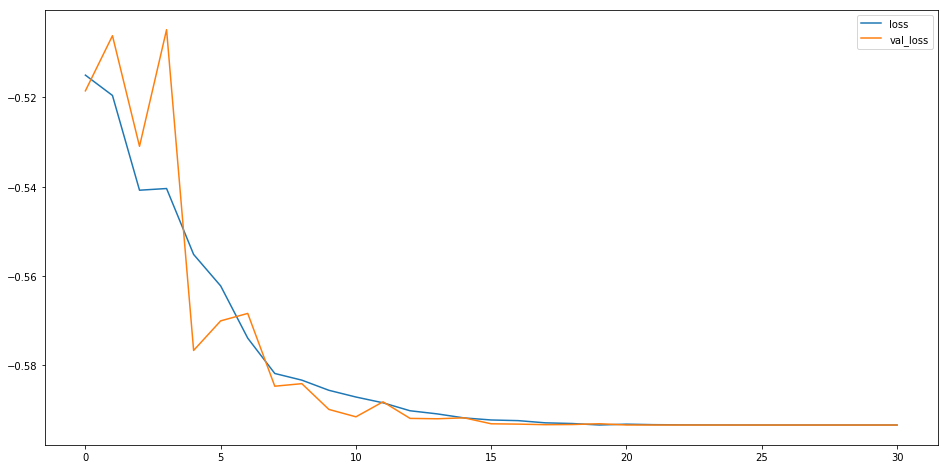

In [40]:
pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))

In [41]:
def make_forecast(model):
    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    feat = make_feat(votes_test)
    df = model.predict(feat)
    df = pd.DataFrame(df, index=feat.index)
    df.to_csv(path / "_sub_full.csv", header=False)
    # path.rename(path.parent / f"{subdir}-{score:0.1f}")

In [42]:
make_forecast(model)